# LB:0.671, 2.5D CNN Baseline（More TTA trick）
competition : 1st and Future - Player Contact Detection  
notebook link : https://www.kaggle.com/code/royalacecat/lb-0-671-2-5d-cnn-baseline-more-tta-trick  

def create_features 코드를 알아보기 어려워서 약간 풀어봤습니다.  

In [2]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions download -c nfl-player-contact-detection

 99% 3.82G/3.84G [00:22<00:00, 227MB/s]
100% 3.84G/3.84G [00:22<00:00, 181MB/s]


In [3]:
# ! pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 904.4 kB/s eta 0:00:00


In [4]:
# !unzip "/content/nfl-player-contact-detection.zip"

Archive:  /content/nfl-player-contact-detection.zip
  inflating: sample_submission.csv   
  inflating: test/58168_003392_All29.mp4  
  inflating: test/58168_003392_Endzone.mp4  
  inflating: test/58168_003392_Sideline.mp4  
  inflating: test/58172_003247_All29.mp4  
  inflating: test/58172_003247_Endzone.mp4  
  inflating: test/58172_003247_Sideline.mp4  
  inflating: test_baseline_helmets.csv  
  inflating: test_player_tracking.csv  
  inflating: test_video_metadata.csv  
  inflating: train/58168_003392_All29.mp4  
  inflating: train/58168_003392_Endzone.mp4  
  inflating: train/58168_003392_Sideline.mp4  
  inflating: train/58172_003247_All29.mp4  
  inflating: train/58172_003247_Endzone.mp4  
  inflating: train/58172_003247_Sideline.mp4  
  inflating: train/58173_003606_All29.mp4  
  inflating: train/58173_003606_Endzone.mp4  
  inflating: train/58173_003606_Sideline.mp4  
  inflating: train/58174_001792_All29.mp4  
  inflating: train/58174_001792_Endzone.mp4  
  inflating: train/58

In [5]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import random
import math
import gc
import cv2
from tqdm import tqdm
import time
# 메모이제이션을 하게 만들어주는 코드.
# 함수위에 @lru_cache를 사용하면되나, 해당 노트북에서는 주석처리됨
from functools import lru_cache
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
# 사전학습된 model을 torch에서 사용하기 위함
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

In [6]:
CFG = {
    'seed' : 42,
    'model' : 'resnet50',
    'img_size' : 256,
    'epochs' : 10,
    'train_bs' : 100,
    'valid_bs' : 64,
    'lr' : 1e-3,
    'weight_decay' : 1e-6,
    'num_workers' : 2
}

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
def expand_contact_id(df):
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df

In [9]:
labels = expand_contact_id(pd.read_csv("/content/sample_submission.csv"))

test_tracking = pd.read_csv("/content/test_player_tracking.csv")
test_helmets = pd.read_csv("/content/test_baseline_helmets.csv")
test_video_metadata = pd.read_csv("/content/test_video_metadata.csv")

In [10]:
labels.head(2)

,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2
0,58168_003392_0_38590_43854,0,58168_003392,0,38590,43854
1,58168_003392_0_38590_41257,0,58168_003392,0,38590,41257


In [11]:
test_tracking.head(2)

,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
0,58172_003247,58172,3247,41937,2020-09-13T19:30:20.200Z,-272,home,MLB,57,64.28,11.29,4.82,0.46,20.74,12.43,3.13,3.00
1,58172_003247,58172,3247,45345,2020-09-13T19:30:20.200Z,-272,away,ILB,50,76.03,36.74,3.15,0.32,179.52,184.91,1.87,-1.81


In [12]:
test_helmets.head(2)

,game_play,game_key,play_id,view,video,frame,nfl_player_id,player_label,left,width,top,height
0,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,39947,H72,946,25,293,34
1,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,37211,H42,151,25,267,33


In [13]:
!mkdir -p ../work/frames

for video in tqdm(test_helmets.video.unique()):
    if 'Endzone2' not in video:
        # 원본 코드
        # !ffmpeg -i /kaggle/input/nfl-player-contact-detection/test/{video} -q:v 2 -f image2 /kaggle/work/frames/{video}_%04d.jpg -hide_banner -loglevel error
        
        # -i 뒤에는 저장한 파일의 경로를 지정해주세요. 
        # -f 뒤에는 저장할 파일의 경로를 지정해주세요. 출력값은 jpg입니다.
        !ffmpeg -i /content/test/{video} -q:v 2 -f image2 /work/frames/{video}_%04d.jpg -hide_banner -loglevel error

100%|██████████| 4/4 [00:44<00:00, 11.02s/it]


In [14]:
def create_features(df, tr_tracking, merge_col = "step", use_cols = ["x_position", "y_position"]):
    output_cols = []
    df_combo = df.astype({"nfl_player_id_1" : "str"})
    # left_on, right_on은 두 데이터프레임의 이름이 다를 경우 공통으로 맞출 열을 의미함
    # 아래에서는 left_on, right_on에 공통된 컬럼을 여러개 정렬해서 중복을 줄이려고 한 것으로 보임
    df_combo = df_combo.merge(tr_tracking.astype({"nfl_player_id" : "str"})[["game_play", merge_col, "nfl_player_id"] + use_cols],
                              left_on = ["game_play", merge_col, "nfl_player_id_1"],
                              right_on = ["game_play", merge_col, "nfl_player_id"], how = "left")
    df_combo = df_combo.rename(columns = {c:c+"_1" for c in use_cols})
    df_combo = df_combo.drop("nfl_player_id", axis = 1)

    df_combo = df_combo.merge(tr_tracking.astype({"nfl_player_id" : "str"})[["game_play", merge_col, "nfl_player_id"] + use_cols], 
                              left_on = ["game_play", merge_col, "nfl_player_id_2"],
                              right_on = ["game_play", merge_col, "nfl_player_id"], how = "left")
    df_combo = df_combo.drop("nfl_player_id", axis = 1)
    df_combo = df_combo.rename(columns = {c: c+"_2" for c in use_cols})

    df_combo = df_combo.sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
    df_combo = df_combo.reset_index(drop = True)

    output_cols += [c + "_1" for c in use_cols]
    output_cols += [c + "_2" for c in use_cols]

    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo["x_position_2"].notnull()
        distance_arr = np.full(len(index), np.nan) 
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"] - df_combo.loc[index, "y_position_2"]))
        
        distance_arr[index] = tmp_distance_arr
        df_combo["distance"] = distance_arr
        output_cols += ["distance"]

    df_combo["G_flug"] = df_combo["nfl_player_id_2"] == "G"
    output_cols += ["G_flug"]
    
    return df_combo, output_cols

use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]

test, feature_cols = create_features(labels, test_tracking, use_cols = use_cols)
test

,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2,x_position_1,y_position_1,speed_1,distance_1,...,x_position_2,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug
0,58168_003392_0_37084_37211,0,58168_003392,0,37084,37211,41.90,20.08,0.54,0.06,...,39.59,17.07,0.53,0.05,134.84,84.73,1.43,1.42,3.794232,False
1,58168_003392_0_37084_38556,0,58168_003392,0,37084,38556,41.90,20.08,0.54,0.06,...,41.93,30.61,0.67,0.05,232.50,227.00,1.82,1.61,10.530043,False
2,58168_003392_0_37084_38567,0,58168_003392,0,37084,38567,41.90,20.08,0.54,0.06,...,40.37,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False
3,58168_003392_0_37084_38590,0,58168_003392,0,37084,38590,41.90,20.08,0.54,0.06,...,40.33,25.28,0.52,0.06,141.08,100.37,0.59,0.58,5.431841,False
4,58168_003392_0_37084_39947,0,58168_003392,0,37084,39947,41.90,20.08,0.54,0.06,...,40.11,26.73,0.99,0.09,163.38,90.69,1.68,1.64,6.886697,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49583,58172_003247_125_52521_52939,0,58172_003247,125,52521,52939,23.44,4.04,1.41,0.15,...,37.94,2.10,2.29,0.24,211.73,215.11,2.43,-2.43,14.629204,False
49584,58172_003247_125_52521_G,0,58172_003247,125,52521,G,23.44,4.04,1.41,0.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
49585,58172_003247_125_52852_52939,0,58172_003247,125,52852,52939,32.67,2.18,2.34,0.24,...,37.94,2.10,2.29,0.24,211.73,215.11,2.43,-2.43,5.270607,False
49586,58172_003247_125_52852_G,0,58172_003247,125,52852,G,32.67,2.18,2.34,0.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [15]:
# df.query(조건문) 형식으로 값을 추출. 가독성이 좋지만 속도가 느린 것이 단점
test_filtered = test.query("not distance>2").reset_index(drop = True)
test_filtered["frame"] = (test_filtered["step"] / 10 * 59.94 + 5 * 59.94).astype("int") + 1
test_filtered

,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2,x_position_1,y_position_1,speed_1,distance_1,...,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug,frame
0,58168_003392_0_37084_38567,0,58168_003392,0,37084,38567,41.90,20.08,0.54,0.06,...,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False,300
1,58168_003392_0_37084_G,0,58168_003392,0,37084,G,41.90,20.08,0.54,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
2,58168_003392_0_37211_46445,0,58168_003392,0,37211,46445,39.59,17.07,0.53,0.05,...,18.08,1.10,0.10,148.93,92.39,2.03,2.03,1.258014,False,300
3,58168_003392_0_37211_G,0,58168_003392,0,37211,G,39.59,17.07,0.53,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
4,58168_003392_0_38556_G,0,58168_003392,0,38556,G,41.93,30.61,0.67,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6626,58172_003247_125_48241_G,0,58172_003247,125,48241,G,33.86,-1.28,0.79,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049
6627,58172_003247_125_48335_G,0,58172_003247,125,48335,G,44.74,3.16,4.72,0.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049
6628,58172_003247_125_52521_G,0,58172_003247,125,52521,G,23.44,4.04,1.41,0.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049
6629,58172_003247_125_52852_G,0,58172_003247,125,52852,G,32.67,2.18,2.34,0.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049


In [16]:
del test, labels, test_tracking
gc.collect()

16

In [17]:
# albumentation을 사용할 때 마지막에 ToTensorV2를 사용하면 torch타입으로 변환된 데이터를 얻을 수 있음.
# 추가해주지 않는다면 numpy 값을 가지게 되므로 토치를 사용할 경우 변경해주어야 함

# 50% 확률로 좌우반전 -> HorizontalFlip
# 50% 확률로 크기 및 각도 변경 -> ShiftScaleRotate
# 기본은 shift_limit = 0.0625, scale_limit = 0.1
train_aug = A.Compose([
    A.HorizontalFlip(p = 0.5),
    A.ShiftScaleRotate(p = 0.5),
    A.RandomBrightnessContrast(brightness_limit = (-0.1, 0.1), contrast_limit = (-0.1, 0.1), p=0.5),
    A.Normalize(mean = [0.], std = [1.]),
    ToTensorV2()
])

valid_aug = A.Compose([
    A.Normalize(mean = [0.], std = [1.]),
    ToTensorV2()
])

In [18]:
video2helmets = {}
# set_index를 사용하면 지정한 컬럼이 index를 대체하게 되고, 기존 값은 없어짐
test_helmets_new = test_helmets.set_index("video")
# tqdm(파일경로) 
for video in tqdm(test_helmets.video.unique()):
    video2helmets[video] = test_helmets_new.loc[video].reset_index(drop = True)

del test_helmets, test_helmets_new
gc.collect()

100%|██████████| 4/4 [00:00<00:00, 75.72it/s]


18

In [19]:
video2frames = {}

for game_play in tqdm(test_video_metadata.game_play.unique()):
    for view in ['Endzone', 'Sideline']:
        video = game_play + f'_{view}.mp4'
        video2frames[video] = max(list(map(lambda x:int(x.split('_')[-1].split('.')[0]), \
                                           glob.glob(f'/work/frames/{video}*'))))

100%|██████████| 2/2 [00:00<00:00, 64.64it/s]


In [20]:
class MyDataset(Dataset):
    def __init__(self, df, aug=valid_aug, mode='train'):
        self.df = df
        self.frame = df.frame.values
        self.feature = df[feature_cols].fillna(-1).values
        self.players = df[['nfl_player_id_1','nfl_player_id_2']].values
        self.game_play = df.game_play.values
        self.aug = aug
        self.mode = mode
        
    def __len__(self):
        return len(self.df)


    # @lru_cache(1024) # 메모이제이션을 위해 사용하는 매직메서드. 위에서 import 했음
    # def read_img(self, path):
    #     return cv2.imread(path, 0)
   
    def __getitem__(self, idx):   
        window = 24
        frame = self.frame[idx]
        
        if self.mode == 'train':
            frame = frame + random.randint(-6, 6)

        players = []
        for p in self.players[idx]:
            if p == 'G':
                players.append(p)
            else:
                players.append(int(p))
        
        imgs = []
        for view in ['Endzone', 'Sideline']:
            video = self.game_play[idx] + f'_{view}.mp4'

            tmp = video2helmets[video]
#             tmp = tmp.query('@frame-@window<=frame<=@frame+@window')
            tmp[tmp['frame'].between(frame-window, frame+window)]
            tmp = tmp[tmp.nfl_player_id.isin(players)]#.sort_values(['nfl_player_id', 'frame'])
            tmp_frames = tmp.frame.values
            tmp = tmp.groupby('frame')[['left','width','top','height']].mean()


            bboxes = []
            for f in range(frame-window, frame+window+1, 1):
                if f in tmp_frames:
                    x, w, y, h = tmp.loc[f][['left','width','top','height']]
                    bboxes.append([x, w, y, h])
                else:
                    bboxes.append([np.nan, np.nan, np.nan, np.nan])
            bboxes = pd.DataFrame(bboxes).interpolate(limit_direction='both').values
            bboxes = bboxes[::4]

            if bboxes.sum() > 0:
                flag = 1
            else:
                flag = 0

                    
            for i, f in enumerate(range(frame-window, frame+window+1, 4)):
                img_new = np.zeros((256, 256), dtype=np.float32)

                if flag == 1 and f <= video2frames[video]:
                    img = cv2.imread(f'/work/frames/{video}_{f:04d}.jpg', 0)

                    x, w, y, h = bboxes[i]

                    img = img[int(y+h/2)-128:int(y+h/2)+128,int(x+w/2)-128:int(x+w/2)+128].copy()
                    img_new[:img.shape[0], :img.shape[1]] = img
                    
                imgs.append(img_new)

                
        feature = np.float32(self.feature[idx])

        img = np.array(imgs).transpose(1, 2, 0)    
        img = self.aug(image=img)["image"]
        label = np.float32(self.df.contact.values[idx])

        return img, feature, label

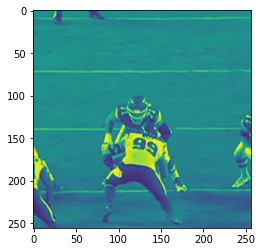

(torch.Size([26, 256, 256]),
 array([4.1900002e+01, 2.0080000e+01, 5.4000002e-01, 5.9999999e-02,
        2.5269000e+02, 2.6231000e+02, 9.2000002e-01, 8.9999998e-01,
        4.0369999e+01, 1.9879999e+01, 6.6000003e-01, 7.0000000e-02,
        1.3670000e+02, 8.8919998e+01, 8.9999998e-01, 8.8999999e-01,
        1.5430166e+00, 0.0000000e+00], dtype=float32),
 0.0)

In [21]:
img, feature, label = MyDataset(test_filtered, valid_aug, 'test')[0]
plt.imshow(img.permute(1,2,0)[:,:,7])
plt.show()
img.shape, feature, label

In [22]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = timm.create_model(CFG["model"], pretrained = False, num_classes = 500, in_chans = 13)
        self.mlp = nn.Sequential(
            nn.Linear(18, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            # nn.Linear(64, 64),
            # nn.LayerNorm(64),
            # nn.ReLU(),
            # nn.Dropout(0.2)
        )
        self.fc = nn.Linear(64+500*2, 1)
    
    def forward(self, img, feature):
        b,c,h,w = img.shape
        img = img.reshape (b*2, c//2, h, w)
        img = self.backbone(img).reshape(b,-1)
        feature = self.mlp(feature)
        y =  self.fc(torch.cat([img, feature], dim = 1))
        return y

In [24]:
test_set = MyDataset(test_filtered, valid_aug, 'test')
test_loader = DataLoader(test_set, batch_size=CFG['valid_bs'], shuffle=False, num_workers=CFG['num_workers'], pin_memory=True)

model = Model().to(device)
# 원 작성자가 올려둔 파일을 불러오겠습니다.
model.load_state_dict(torch.load('/content/resnet50_fold0.pt'))

model.eval()
    
y_pred = []
with torch.no_grad():
    tk = tqdm(test_loader, total=len(test_loader))
    for step, batch in enumerate(tk):
        if(step % 4 != 3):
            img, feature, label = [x.to(device) for x in batch]
            output1 = model(img, feature).squeeze(-1)
            output2 = model(img.flip(-1), feature).squeeze(-1)
            
            y_pred.extend(0.2*(output1.sigmoid().cpu().numpy()) + 0.8*(output2.sigmoid().cpu().numpy()))
        else:
            img, feature, label = [x.to(device) for x in batch]
            output = model(img.flip(-1), feature).squeeze(-1)
            y_pred.extend(output.sigmoid().cpu().numpy())    

y_pred = np.array(y_pred)

100%|██████████| 104/104 [15:47<00:00,  9.11s/it]


In [25]:
th = 0.29

test_filtered['contact'] = (y_pred >= th).astype('int')

sub = pd.read_csv('/content/sample_submission.csv')

sub = sub.drop("contact", axis=1).merge(test_filtered[['contact_id', 'contact']], how='left', on='contact_id')
sub['contact'] = sub['contact'].fillna(0).astype('int')

sub[["contact_id", "contact"]].to_csv("submission.csv", index=False)

sub.head()

,contact_id,contact
0,58168_003392_0_38590_43854,0
1,58168_003392_0_38590_41257,0
2,58168_003392_0_38590_41944,0
3,58168_003392_0_38590_42386,0
4,58168_003392_0_38590_47944,0


당분간, 최신 모델 사용보다는 베이스라인을 위주로 필사하려고 합니다.  
영상쪽은 처음봤는데 이해가 되지 않는 부분이 가끔씩 나와서 필사하는데 꽤 시간이 걸렸습니다.  
기본기가 어느정도 잡혔다고 판단되면 본격적으로 대회에 참여해 보는게 좋을 것 같습니다.